# From Tensors to Cloud—Zarr-Python 3 @ PyCon DE & PyData 2025

In [1]:
import zarr
import numpy as np
from PIL import Image
from matplotlib import pyplot

In [2]:
zarr.__version__

'3.0.6'

## Creating a Zarr array

In [3]:
store = zarr.storage.MemoryStore() #initialising the store

z = zarr.create_array(store=store, shape=(10000, 10000), chunks=(1000, 1000), dtype='int32') #using the new create_array function

In [4]:
z.info

Type               : Array
Zarr format        : 3
Data type          : DataType.int32
Shape              : (10000, 10000)
Chunk shape        : (1000, 1000)
Order              : C
Read-only          : False
Store type         : MemoryStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 400000000 (381.5M)

In [5]:
z.info_complete()

Type               : Array
Zarr format        : 3
Data type          : DataType.int32
Shape              : (10000, 10000)
Chunk shape        : (1000, 1000)
Order              : C
Read-only          : False
Store type         : MemoryStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 400000000 (381.5M)
No. bytes stored   : 645
Storage ratio      : 620155.0
Chunks Initialized : 0

## Writing data to the array

In [6]:
z[:] = 9

In [7]:
z.info_complete()

Type               : Array
Zarr format        : 3
Data type          : DataType.int32
Shape              : (10000, 10000)
Chunk shape        : (1000, 1000)
Order              : C
Read-only          : False
Store type         : MemoryStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 400000000 (381.5M)
No. bytes stored   : 39145
Storage ratio      : 10218.4
Chunks Initialized : 100

## Working with attributes

In [8]:
z.attrs['sample_data'] = 'units'

In [9]:
print(dict(z.attrs))

{'sample_data': 'units'}


## Persistent arrays

Zarr arrays can be stored on a file system, enabling persistence of data between sessions.

In [10]:
z1 = zarr.create_array(store='data/example-1.zarr', shape=(10000, 10000), chunks=(1000, 1000), dtype='int32')

In [11]:
z1[:] = 9

In [12]:
z1.info_complete()

Type               : Array
Zarr format        : 3
Data type          : DataType.int32
Shape              : (10000, 10000)
Chunk shape        : (1000, 1000)
Order              : C
Read-only          : False
Store type         : LocalStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 400000000 (381.5M)
No. bytes stored   : 39145
Storage ratio      : 10218.4
Chunks Initialized : 100

There is no need to close an array: data are automatically flushed to disk, and files are automatically closed whenever an array is modified.

## Using compressors

Zarr includes Blosc, Zstandard and Gzip compressors. Additional compressors are available through a separate package called Numcodecs.

In [13]:
compressors = zarr.codecs.BloscCodec(cname='zstd', clevel=3, shuffle=zarr.codecs.BloscShuffle.bitshuffle)
data = np.arange(100000000, dtype='int32').reshape(10000, 10000)

z3 = zarr.create_array(store='data/example-2.zarr', shape=data.shape, dtype=data.dtype, chunks=(1000, 1000), compressors=compressors)

This array above will use Blosc as the primary compressor, using the Zstandard algorithm (compression level 3) internally within Blosc, and with the bit-shuffle filter applied.

In [14]:
z3[:] = data
z3.compressors

(BloscCodec(typesize=4, cname=<BloscCname.zstd: 'zstd'>, clevel=3, shuffle=<BloscShuffle.bitshuffle: 'bitshuffle'>, blocksize=0),)

In [15]:
z3.info_complete()

Type               : Array
Zarr format        : 3
Data type          : DataType.int32
Shape              : (10000, 10000)
Chunk shape        : (1000, 1000)
Order              : C
Read-only          : False
Store type         : LocalStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (BloscCodec(typesize=4, cname=<BloscCname.zstd: 'zstd'>, clevel=3, shuffle=<BloscShuffle.bitshuffle: 'bitshuffle'>, blocksize=0),)
No. bytes          : 400000000 (381.5M)
No. bytes stored   : 9696520
Storage ratio      : 41.3
Chunks Initialized : 100

# Creating Zarr groups

In [16]:
store = zarr.storage.LocalStore(root='data/example3.zarr')
root = zarr.create_group(store=store)

foo = root.create_group('foo')
bar = foo.create_group('bar')

z4 = bar.create_array(name='baz', shape=(10000, 10000), chunks=(1000, 1000), dtype='int32')

In [17]:
root.tree()

/
└── foo
    └── bar
        └── baz (10000, 10000) int32

In [18]:
root.info_complete()

Name        : 
Type        : Group
Zarr format : 3
Read-only   : False
Store type  : LocalStore
No. members : 3
No. arrays  : 1
No. groups  : 2

## Batch group creation

You can create multiple groups concurrently with a single function call. 

In [19]:
from zarr import create_hierarchy
from zarr.core.group import GroupMetadata
from zarr.storage import LocalStore

node_spec = {'a/b/c': GroupMetadata()}
nodes_created = dict(create_hierarchy(store=LocalStore(root='data'), nodes=node_spec))

In [20]:
print(sorted(nodes_created.items(), key=lambda kv: len(kv[0])))

[('', <Group file://data>), ('a', <Group file://data/a>), ('a/b', <Group file://data/a/b>), ('a/b/c', <Group file://data/a/b/c>)]


We only specified a single group named a/b/c, but 4 groups were created. Additional groups were created to ensure that the desired node a/b/c is connected to the root group '' by a sequence of intermediate groups.

# Runtime Configuration

In [21]:
zarr.config.set({'array.order': 'F'}) #change the order to column-wise

In [22]:
zarr.config.set({'array.order': 'C'}) #revert the change

# Optimizing Performance

In [23]:
z5 = zarr.create_array(store={}, shape=(10000, 10000), chunks=(100, 10000), dtype='int32') # slicing across the first dimension
z5.chunks

(100, 10000)

In [24]:
z6 = zarr.create_array(store={}, shape=(10000, 10000), chunks=(10000, 100), dtype='int32') # slicing across the second dimension
z6.chunks

(10000, 100)

You can let Zarr guess a chunk shape for your data by providing chunks='auto'.

Note: Guessing a chunk shape is based on simple heuristics and may be far from optimal.

In [25]:
z7 = zarr.create_array(store={}, shape=(10000, 10000), chunks='auto', dtype='int32')
z7.chunks

(625, 625)

# Sharding

Sharding provides a mechanism to store multiple chunks in a single storage object or file. This can be useful because traditional file systems and object storage systems may have performance issues storing and accessing many files.

In [26]:
z8 = zarr.create_array(store={}, shape=(10000, 10000, 1000), shards=(1000, 1000, 1000), chunks=(100, 100, 100), dtype='uint8')

In [27]:
z8.info_complete()

Type               : Array
Zarr format        : 3
Data type          : DataType.uint8
Shape              : (10000, 10000, 1000)
Shard shape        : (1000, 1000, 1000)
Chunk shape        : (100, 100, 100)
Order              : C
Read-only          : False
Store type         : MemoryStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 100000000000 (93.1G)
No. bytes stored   : 1191
Storage ratio      : 83963056.3
Shards Initialized : 0

## Converting Zarr PNG logo to .zarr format

In [28]:
image = Image.open("/Users/msankeys963/Downloads/Zarr Logos/Pixel/zarr_pixel.png")

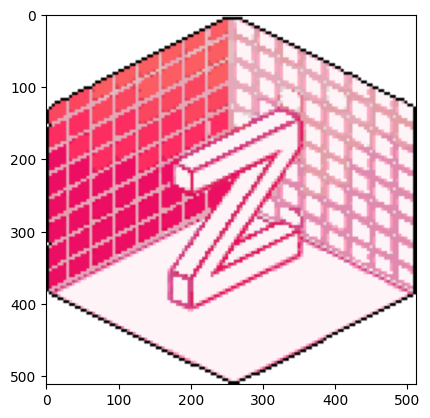

In [29]:
pyplot.imshow(image)

In [30]:
nparray = np.asarray(image)

In [31]:
zarr_logo_zarr = zarr.array(nparray)

In [32]:
zarr_logo_zarr.info_complete()

Type               : Array
Zarr format        : 3
Data type          : DataType.uint8
Shape              : (512, 512, 4)
Chunk shape        : (512, 512, 4)
Order              : C
Read-only          : False
Store type         : MemoryStore
Filters            : ()
Serializer         : BytesCodec(endian=<Endian.little: 'little'>)
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 1048576 (1.0M)
No. bytes stored   : 60726
Storage ratio      : 17.3
Chunks Initialized : 1

In [33]:
zarr_logo_zarr.attrs["Style"] = "Pixelated"
zarr_logo_zarr.attrs["Copyright"] = "Sanket"
zarr_logo_zarr.attrs["Motivation"] = "PyCon DE 2025"

In [34]:
print(dict(zarr_logo_zarr.attrs))

{'Style': 'Pixelated', 'Copyright': 'Sanket', 'Motivation': 'PyCon DE 2025'}


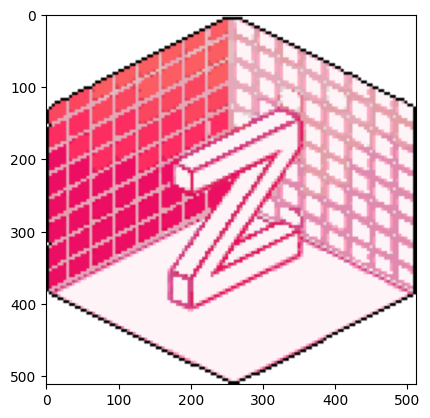

In [35]:
pyplot.imshow(zarr_logo_zarr)

In [36]:
zarr.save(store='data/logo.zarr', data=np)

NameError: name 'numpydata' is not defined